In [1]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime
import re
import os

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

exclude_prefixes = ('@ryancavanaugh/pkg', 'all-packages-', 'cool-', 'neat-', 'wowdude-', 'npmdoc-', 'npmtest-', 'npm-ghost-',)
exclude_suffixes = ('-cdn',)
exclude_ghost = r'^ghost-\d+$'

In [2]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)
    #return lst2
    #print(lst2,cliffsDelta(lst1,lst2)) # should return False

# LOAD DATA

In [3]:
technical_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', usecols=['package','version','kind','constraint_type'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(technical_lag))
technical_lag.head(2)

51351426


,constraint_type,date_last_available,date_used_version,kind,package,version
0,latest,2014-04-01,2014-04-01,runtime,shaybagants-test,1.0.0
1,latest,2014-04-01,2014-04-01,runtime,shaybagants-test,2.0.0


In [4]:
technical_lag=technical_lag.query('kind!="Optional"')
technical_lag['kind']=technical_lag['kind'].apply(lambda x: x.capitalize())
#technical_lag['date']=pd.to_datetime(technical_lag['date'])


In [86]:
technical_lag.drop([#'release_type','used_version',
                    'date_last_available','release_type','dependency','date_used_version','constraint'],
                   #'date_used_version','date_last_available'],
                   axis=1, inplace=True)

In [5]:
# Remove pre-releases
technical_lag = technical_lag[~technical_lag.version.str.contains('-')]

In [6]:
# Remove spam packages
technical_lag=technical_lag[~technical_lag['package'].str.startswith(exclude_prefixes)]
technical_lag=technical_lag[~technical_lag['package'].str.endswith(exclude_suffixes)]
technical_lag=technical_lag[~technical_lag['package'].str.match(exclude_ghost)]

In [16]:
len(technical_lag)

45178711

#### METHOD 

In [2]:
#Here to calculate all dependencies before calculating the technical lag.
deps=pd.read_csv('../../../jsep2018/csv/packages/dependencies_npm_march.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)

In [3]:
print(len(deps),deps.package.drop_duplicates().size, len(deps[['package','version']].drop_duplicates()))

52840196 547335 4015178


In [4]:
deps['package']=deps['package'].apply(str)

In [6]:
# Remove pre-releases
deps = deps[~deps.version.str.contains('-')]

In [7]:
# remove spam packages
deps=deps[~deps['package'].str.startswith(exclude_prefixes)]
deps=deps[~deps['package'].str.endswith(exclude_suffixes)]
deps=deps[~deps['package'].str.match(exclude_ghost)]

In [8]:
print('all dataset',len(deps),'\n',
      'number of packages',deps.package.drop_duplicates().size,'\n',
      'number of versions',len(deps[['package','version']].drop_duplicates()))

all dataset 46016524 
 number of packages 520547 
 number of versions 3637973


In [17]:
len(technical_lag)/len(deps)

0.9817932141071759

In [10]:
deps.groupby('kind').count()

,package,version,dependency,constraint,date,release_type
kind,,,,,,
Development,26650808,26650808,26650054,26650808,26650808,26650808
Optional,281,281,281,281,281,281
runtime,19365435,19365435,19349220,19365435,19365435,19365435


In [11]:
deps.groupby('kind').count()/len(deps)

,package,version,dependency,constraint,date,release_type
kind,,,,,,
Development,0.579157,0.579157,0.579141,0.579157,0.579157,0.579157
Optional,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
runtime,0.420837,0.420837,0.420484,0.420837,0.420837,0.420837


In [72]:
first_date="2010-12-20"
last_date="2018-03-12"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)

# RQ0

In [20]:
df_tmp=technical_lag.groupby(['constraint_type','kind']).count()[['version']].reset_index()

In [25]:
# Constraints for each kind
for kind in ['Development','Runtime']:
    df_tmp=(technical_lag
            .query('kind == "'+kind+'"')
            .groupby(['constraint_type','kind'])
            .count()[['version']]
            .reset_index()
           )
    print(df_tmp)

  constraint_type         kind   version
0           caret  Development  19306123
1          latest  Development    912282
2           other  Development    586684
3          strict  Development   3484110
4           tilde  Development   1810070
  constraint_type     kind   version
0           caret  Runtime  12886260
1          latest  Runtime    758723
2           other  Runtime    821024
3          strict  Runtime   3052352
4           tilde  Runtime   1561083


In [29]:
# Constraints for each kind %
for kind in ['Development','Runtime']:
    df_tmp=(technical_lag
            .query('kind == "'+kind+'"')
            .groupby(['constraint_type'])
            .count()[['version']]
            .reset_index()
           )
    l=float(len(technical_lag.query('kind == "'+kind+'"')))
    df_tmp['version']=df_tmp['version'].apply(lambda x: x*100.0/l)
    print(df_tmp)

  constraint_type    version
0           caret  73.971892
1          latest   3.495431
2           other   2.247894
3          strict  13.349454
4           tilde   6.935328
  constraint_type    version
0           caret  67.540026
1          latest   3.976652
2           other   4.303187
3          strict  15.998120
4           tilde   8.182016


In [30]:
df_tmp=(technical_lag
        .groupby(['constraint_type'])
        .count()[['version']]
        .reset_index()
       )
l=float(len(technical_lag))
df_tmp['version']=df_tmp['version'].apply(lambda x: x*100.0/l)
print(df_tmp)

  constraint_type    version
0           caret  71.255647
1          latest   3.698656
2           other   3.115866
3          strict  14.468013
4           tilde   7.461818


In [31]:
df_tmp=(technical_lag
        .groupby(['constraint_type'])
        .count()[['version']]
        .reset_index()
       )
print(df_tmp)

  constraint_type   version
0           caret  32192383
1          latest   1671005
2           other   1407708
3          strict   6536462
4           tilde   3371153


In [28]:
technical_lag.groupby('kind').count()[['version']]/len(technical_lag)

,version
kind,
Development,0.57769
Runtime,0.42231


In [15]:
df_tmp.groupby(['constraint_type']).sum()

,constraint
constraint_type,
caret,70.562211
latest,2.947625
other,3.399907
strict,15.934057
tilde,7.156200


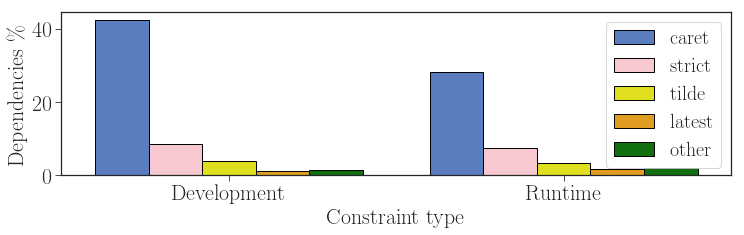

In [20]:
ax = sns.barplot(x="kind", y="constraint", hue="constraint_type", palette=[blue,"pink",'yellow','orange','green'], data=df_tmp,
                hue_order=['caret','strict','tilde','latest','other'])
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/constraints.png', bbox_inches='tight', facecolor='white')

# RQ0 part2

In [3]:
technical_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv',
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(technical_lag))
technical_lag.head(2)

51351426


,constraint,constraint_type,date,date_last_available,date_used_version,dependency,kind,package,release_type,used_version,version,version_lag
0,*,latest,2015-11-11,2014-04-01,2014-04-01,0,runtime,shaybagants-test,initial,0.0.0,1.0.0,"0,0,0"
1,*,latest,2015-11-11,2014-04-01,2014-04-01,0,runtime,shaybagants-test,major,0.0.0,2.0.0,"0,0,0"


In [ ]:
technical_lag=technical_lag.query('kind!="Optional"')
technical_lag['kind']=technical_lag['kind'].apply(lambda x: x.capitalize())
#technical_lag['date']=pd.to_datetime(technical_lag['date'])

# Remove pre-releases
technical_lag = technical_lag[~technical_lag.version.str.contains('-')]

# Remove spam packages
technical_lag=technical_lag[~technical_lag['package'].str.startswith(exclude_prefixes)]
technical_lag=technical_lag[~technical_lag['package'].str.endswith(exclude_suffixes)]
technical_lag=technical_lag[~technical_lag['package'].str.match(exclude_ghost)]

In [ ]:
technical_lag['date_used_version']=pd.to_datetime(technical_lag['date_used_version'])
technical_lag['date_last_available']=pd.to_datetime(technical_lag['date_last_available'])

In [ ]:
technical_lag['time_lag']=technical_lag['date_last_available'] - technical_lag['date_used_version']
technical_lag.drop(['date_last_available','date_used_version'], axis=1, inplace=True)

In [ ]:
technical_lag=technical_lag[['package','version','date','dependency','constraint','kind','constraint_type','time_lag','version_lag']]

In [ ]:
next_lag = technical_lag

In [ ]:
next_lag['dependency_next']=next_lag.dependency.shift(-1)
next_lag['time_lag_next']=next_lag.time_lag.shift(-1)
next_lag['constraint_type_next']=next_lag.constraint_type.shift(-1)
next_lag['date_next']=next_lag.date.shift(-1)
next_lag['package_next']=next_lag.package.shift(-1)
next_lag['version_next']=next_lag.version.shift(-1)
next_lag['constraint_next']=next_lag.constraint.shift(-1)

In [ ]:
next_lag=next_lag.query('dependency==dependency_next and package==package_next')

In [ ]:
next_lag.sort_values(['package','dependency','date'], ascending=True, inplace=True)

In [28]:
versions=pd.read_csv('../../../jsep2018/csv/versions_npm_march.csv', sep=';', 
                     #usecols=['package','version','release_type'],
                     dtype=object, index_col=None,  error_bad_lines=False)
print(len(versions))
versions.head(2)

4760450


,package,version,date,release_type,semver,Major,Minor,Patch
0,0,0.0.0,2014-04-01,initial,0.0.0,0,0,0
1,0-,0.0.1,2017-03-06,initial,0.0.1,0,0,1


In [19]:
versions['package']=versions['package'].apply(str)

In [20]:
versions=versions[~versions['package'].str.startswith(exclude_prefixes)]
versions=versions[~versions['package'].str.endswith(exclude_suffixes)]
versions=versions[~versions['package'].str.match(exclude_ghost)]

# When do packages UPDATE constraint, in general?

In [8]:
df_tmp=next_lag[['package','version','version_next','date','date_next','kind','dependency','constraint','constraint_next','constraint_type','constraint_type_next']]


In [9]:
versions=versions[['package','version','release_type']]
df_tmp=df_tmp.query('constraint != constraint_next')
df_tmp=df_tmp[['package','version','version_next','date','date_next','kind','dependency','constraint_type','constraint_type_next']]

In [10]:
df_tmp['package']=df_tmp['package'].apply(str)
df_tmp['version']=df_tmp['version'].apply(str)
df_tmp['version_next']=df_tmp['version_next'].apply(str)

versions['package']=versions['package'].apply(str)
versions['version']=versions['version'].apply(str)

In [11]:
df_tmp=(df_tmp
        .set_index(['package','version'])
       .merge(versions
              .set_index(['package','version']),
              left_index=True,
              right_index=True,
              how='left')
        .dropna()
        .reset_index()
       )
len(df_tmp)

2219878

In [12]:
df_tmp_update=(df_tmp
        .set_index(['package','version_next'])
       .merge(versions
              .rename(columns={'version':'version_next','release_type':'release_type_next'})
              .set_index(['package','version_next']),
              left_index=True,
              right_index=True,
              how='left')
        .dropna()
        .reset_index()
       )
len(df_tmp_update)

2219878

In [13]:
df_tmp2=df_tmp_update.groupby(['package','version','release_type','release_type_next']).count()[['dependency']].reset_index()
df_tmp2.head(2)

,package,version,release_type,release_type_next,dependency
0,0.0.0-development,1.0.0,initial,patch,1
1,0.workspace,0.0.15,patch,patch,1


In [14]:
print(df_tmp2.query('release_type_next=="patch"').dependency.median(),
      df_tmp2.query('release_type_next=="minor"').dependency.median(),
      df_tmp2.query('release_type_next=="major"').dependency.median()
     )

1.0 2.0 2.0


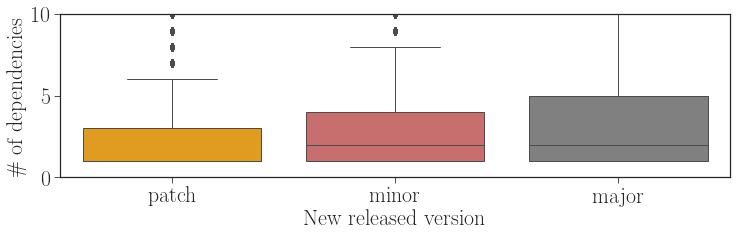

In [15]:
# When 
ax = sns.boxplot(x="release_type_next", 
                 y="dependency", 
                 data=df_tmp2, 
                 #hue='release_type_next', hue_order=['patch','minor','major'],
                 order=['patch','minor','major'],
                 palette=version_colors, linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("New released version")
ax.set_ylabel('\# of dependencies')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_ylim(0,10)
#ax.text(0.12, 1.2, 'To: ', transform=ax.transAxes, fontsize=20,
#        verticalalignment='top', color='black')
ax.legend(loc='upper right', bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/update_constraints.eps', bbox_inches='tight', facecolor='white')

# How often packages are updated

In [21]:
tab=[]
tmp=pd.DataFrame()
for release in ['initial','patch','minor','major']:
    for next_release in ['patch','minor','major']:
        tmp=versions.query('release_type=="'+release+'" or release_type=="'+next_release+'"')
        
        tmp['date_next']=tmp.date.shift(-1)
        tmp['release_type_next']=tmp.release_type.shift(-1)
        tmp['package_next']=tmp.package.shift(-1)
        
        tmp=tmp.query('package==package_next')
        tmp=tmp.query('release_type=="'+release+'" and release_type_next=="'+next_release+'"')
        tab.append(tmp)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [23]:
df_tmp=pd.concat(tab)
df_tmp['date']=pd.to_datetime(df_tmp['date'])
df_tmp['date_next']=pd.to_datetime(df_tmp['date_next'])

df_tmp['time']=(df_tmp['date_next'] - df_tmp['date']).dt.days

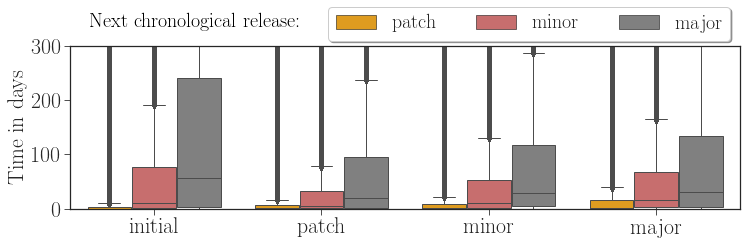

In [27]:
# When 
ax = sns.boxplot(x="release_type", 
                 y="time", 
                 data=df_tmp, 
                 hue='release_type_next', hue_order=['patch','minor','major'],
                 order=['initial','patch','minor','major'],
                 palette=version_colors, linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("")
ax.set_ylabel('Time in days')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_ylim(0,300)
ax.text(0.03, 1.2, 'Next chronological release: ', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/next_release.eps', bbox_inches='tight', facecolor='white')

# RQ1

In [ ]:
dep_lag = pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', 
                    usecols=['package','version','version_lag','kind','date'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(dep_lag))
dep_lag.head(2)

In [4]:
dep_lag = dep_lag[~dep_lag.version.str.contains('-')]

In [5]:
dep_lag = dep_lag[~dep_lag['package'].str.startswith(exclude_prefixes)]
dep_lag = dep_lag[~dep_lag['package'].str.endswith(exclude_suffixes)]
dep_lag = dep_lag[~dep_lag['package'].str.match(exclude_ghost)]

In [6]:
len(dep_lag)

45178989

In [7]:
print(len(dep_lag.query('version_lag=="0,0,0"')),
      len(dep_lag.query('version_lag!="0,0,0"')))

33511815 11667174


In [8]:
len(dep_lag.query('version_lag!="0,0,0"'))/len(dep_lag)

0.2582433617538454

In [9]:
dep_lag.query('version_lag!="0,0,0"').groupby('kind').count()[['package']]/len(dep_lag.query('version_lag!="0,0,0"'))

,package
kind,
Development,0.680696
Optional,0.000010
runtime,0.319294


In [10]:
dep_lag.query('version_lag!="0,0,0"').groupby('kind').count()[['package']]

,package
kind,
Development,7941801
Optional,116
runtime,3725257


In [11]:
dep_lag.query('version_lag=="0,0,0"').groupby('kind').count()[['package']]/len(dep_lag.query('version_lag=="0,0,0"'))

,package
kind,
Development,0.541823
Optional,0.000005
runtime,0.458172


In [12]:
dep_lag.query('version_lag=="0,0,0"').groupby('kind').count()[['package']]

,package
kind,
Development,18157468
Optional,162
runtime,15354185


### Outdated Packages

In [ ]:
dep_lag.query('version_lag!="0,0,0"')

### Time lag

In [15]:
dep_lag = dep_lag.query('version_lag!="0,0,0"')

In [16]:
dep_lag['date_used_version']=pd.to_datetime(dep_lag['date_used_version'])
dep_lag['date_last_available']=pd.to_datetime(dep_lag['date_last_available'])

In [24]:
dep_lag['time_lag']=dep_lag['date_last_available'] - dep_lag['date_used_version']

In [28]:
time_lag=dep_lag[['package','version','date','kind','time_lag']]
time_lag['time_lag']=time_lag['time_lag'].apply(lambda x : float(str(x).split()[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
time_lag = time_lag.query('time_lag != 0')
time_lag['date']=pd.to_datetime(time_lag['date'])

In [30]:
time_lag_max=time_lag.groupby(['package','version','kind','date']).agg('max').reset_index()
len(time_lag_max)

2899421

In [31]:
time_lag_max['date']=pd.to_datetime(time_lag_max['date'])
time_lag_max['time_lag']=time_lag_max['time_lag'].apply(float)


In [32]:
scipy.stats.mannwhitneyu(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="runtime"').time_lag)

MannwhitneyuResult(statistic=947904848760.0, pvalue=0.0)

In [35]:
cliffsDelta(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="runtime"').time_lag)

d=0.07440429288927344


False

In [36]:
time_lag_max.query('time_lag!=0').query('kind=="runtime"').time_lag.median()

160.0

In [37]:
time_lag_max.query('time_lag!=0').query('kind=="Development"').time_lag.median()

195.0

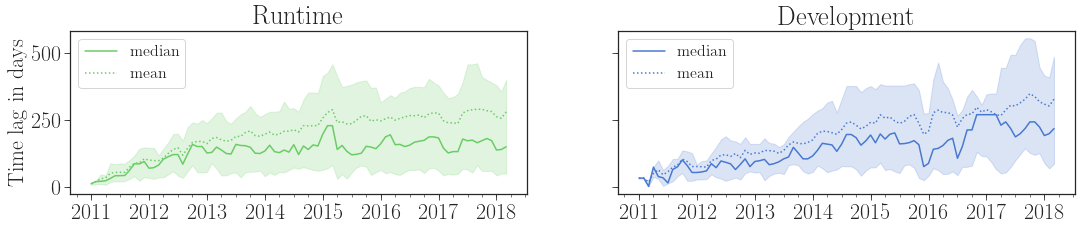

In [41]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, genre in enumerate(['runtime','Development']):
    size=[12,20,70]
    df_=(time_lag_max.
         query('time_lag!=0').
         query('kind=="{}"'.format(genre)).
         groupby(pd.Grouper(key='date', freq='1M'))['time_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )
    genre=genre.capitalize()
    if genre =="Runtime":
        color=green
    else:
        color=blue

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=color)
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=color)
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=color)

    ax.set(
        xlabel='',
        ylabel='Time lag in days'.format(genre),
        #xlim=date_period,
        #ylim=(0,size),
        title=genre
    )
    ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
fig.savefig('../../../../repositories/jsep18technicallag/figures/time_lag.png', bbox_inches='tight', facecolor='white')


In [63]:
df_['50%'].max()

270.0

In [46]:
for x in range(2010, 2018):
    first=str(x)
    last=str(x+1)
    a=time_lag_max.query('date>"'+first+'" and date<"'+last+'"')
    print(first,last)
    print( scipy.stats.mannwhitneyu(a.query('kind=="Development"').time_lag,
                                    a.query('kind=="runtime"').time_lag))

2010 2011
MannwhitneyuResult(statistic=0.0, pvalue=0.0)
2011 2012
MannwhitneyuResult(statistic=2299946.5, pvalue=0.44433028424297838)
2012 2013
MannwhitneyuResult(statistic=55585013.5, pvalue=5.2786163179451937e-82)
2013 2014
MannwhitneyuResult(statistic=845536881.0, pvalue=3.2392602577436822e-145)
2014 2015


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:4897: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=6330515524.5, pvalue=7.8253155146745007e-45)
2015 2016
MannwhitneyuResult(statistic=22328043682.5, pvalue=0.055973442411739217)
2016 2017
MannwhitneyuResult(statistic=72090711169.5, pvalue=6.0207044605379801e-54)
2017 2018
MannwhitneyuResult(statistic=158630582656.5, pvalue=0.0)


In [59]:
for b in range(2011,2018):
    first=str(b)
    last=str(b+1)
    a=time_lag_max.query('date>"'+first+'" and date<"'+last+'"')
    print(first,last)
    print(cliffsDelta(a.query('kind=="Development"').time_lag,
                                    a.query('kind=="runtime"').time_lag))

2011 2012
d=0.002520429290497962
False
2012 2013
d=-0.14768304703888357
True
2013 2014
d=-0.10051361198376367
False
2014 2015
d=0.0337858769730778
False
2015 2016
d=0.0028246304357184035
False
2016 2017
d=0.020516406544691303
False
2017 2018
d=0.1264832970181366
False


### Version lag

In [64]:
version_lag_sum=dep_lag.query('version_lag!="0,0,0"')[['package','version','version_lag','date','kind']]
len(version_lag_sum)/len(dep_lag)

1.0

In [65]:
version_lag_sum=(version_lag_sum.
                 assign(version_major=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[0])) ).
                 assign(version_minor=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[1]))  ).
                 assign(version_patch=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[2])) )
                )
                 

In [66]:
version_lag_sum.drop('version_lag', axis=1, inplace=True)

In [67]:
version_lag_sum=version_lag_sum.groupby(['package','version','date','kind']).agg('sum')
version_lag_sum.reset_index(inplace=True)

In [68]:
version_lag_sum['date']=pd.to_datetime(version_lag_sum['date'])
version_lag_sum.rename(columns={'version_major':'Major','version_minor':'Minor','version_patch':'Patch'}, inplace=True)
for x in ['Minor','Patch','Major']:
    version_lag_sum[x]=version_lag_sum[x].apply(float)
version_lag_sum['kind']=version_lag_sum['kind'].apply(lambda x: x.capitalize())
version_lag_sum.head(2)

,package,version,date,kind,Major,Minor,Patch
0,0-,0.0.1,2017-03-06,Development,4.0,4.0,13.0
1,0-9,0.0.1,2017-03-06,Development,4.0,4.0,13.0


In [69]:
#version_lag_sum=version_lag_sum[~version_lag_sum['package'].str.startswith(exclude_prefixes)]
#version_lag_sum=version_lag_sum[~version_lag_sum['package'].str.endswith(exclude_suffixes)]
#version_lag_sum=version_lag_sum[~version_lag_sum['package'].str.match(exclude_ghost)]

In [70]:
for kind in ['Development','Runtime']:
    dd=version_lag_sum.query('kind=="'+kind+'"')
    print(kind)
    print(dd.Major.median(),dd.Minor.median(),dd.Patch.median())

Development
2.0 2.0 9.0
Runtime
1.0 1.0 4.0


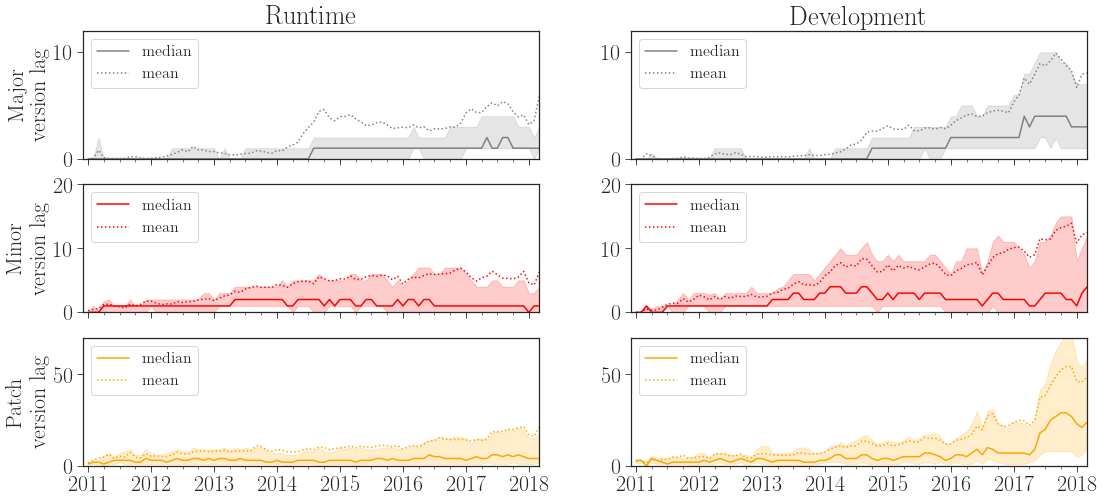

In [74]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)
fig.set_size_inches(18,8)
for index, genre in enumerate(['Runtime','Development']):
    size=[12,20,70]
    dfs={}
    for x in ['Patch','Minor','Major']:
        dfs[x]=(version_lag_sum.query('kind=="{}"'.format(genre)).
                groupby(pd.Grouper(key='date', freq='1M'))[x].
                describe()[['mean', '25%', '50%', '75%']] 
               )

    colors={}
    colors['Patch']='orange'
    colors['Minor']='r'
    colors['Major']='gray'


    for i, x in enumerate(['Major','Minor','Patch']):
        #fig, ax = plt.subplots()
        df_tmp=dfs[x]
        df_tmp['50%'].rename('median').plot(ax=axes[i][index], color=colors[x])
        df_tmp['mean'].plot(style=':',ax=axes[i][index], color=colors[x])
        axes[i][index].fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)

        axes[i][index].set(
            xlabel='',
            ylabel='{} \n version lag'.format(x),
            xlim=date_period,
            ylim=(0,size[i]),
        )
        if i == 0:
            axes[i][index].set(title=genre)
        if index==1:
            axes[i][index].set(ylabel='')

        axes[i][index].legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

fig.savefig('../../../../repositories/jsep18technicallag/figures/version_lag.pdf', bbox_inches='tight', facecolor='white')

# Remove O.y.z

In [110]:
version_lag_sum=technical_lag.query('version_lag!="0,0,0"').query('constraint_type!="strict"')
len(version_lag_sum)/len(technical_lag)

0.19322459239474268

In [111]:
version_lag_sum['zero']=version_lag_sum['used_version'].apply(lambda x: 'True' if x.split('.')[0]=="0"
                                                             else 'False')

In [112]:
version_lag_sum=version_lag_sum.query('zero=="False"')[['package','version','version_lag','date','kind']]


In [113]:
version_lag_sum=(version_lag_sum.
                 assign(version_major=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[0])) ).
                 assign(version_minor=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[1]))  ).
                 assign(version_patch=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[2])) )
                )
                 

In [114]:
version_lag_sum.drop(['version_lag'], axis=1, inplace=True)

In [115]:
version_lag_sum=version_lag_sum.groupby(['package','version','date','kind']).agg('sum')
version_lag_sum.reset_index(inplace=True)

In [116]:
#version_lag_sum.to_csv('../../../jsep2018/csv/packages/ready/version_lag_sum_zeros.csv', index=False, sep=";")


In [117]:
#version_lag_sum_zeros=pd.read_csv('../../../jsep2018/csv/packages/ready/version_lag_sum_zeros.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)

version_lag_sum_zeros['date']=pd.to_datetime(version_lag_sum_zeros['date'])
version_lag_sum_zeros.rename(columns={'version_major':'Major','version_minor':'Minor','version_patch':'Patch'}, inplace=True)
for x in ['Minor','Patch','Major']:
    version_lag_sum_zeros[x]=version_lag_sum_zeros[x].apply(float)
version_lag_sum_zeros['kind']=version_lag_sum_zeros['kind'].apply(lambda x: x.capitalize())
version_lag_sum_zeros.head(2)

,package,version,date,kind,Major,Minor,Patch
0,0-,0.0.1,2017-03-06,Development,4.0,4.0,13.0
1,0-9,0.0.1,2017-03-06,Development,4.0,4.0,13.0


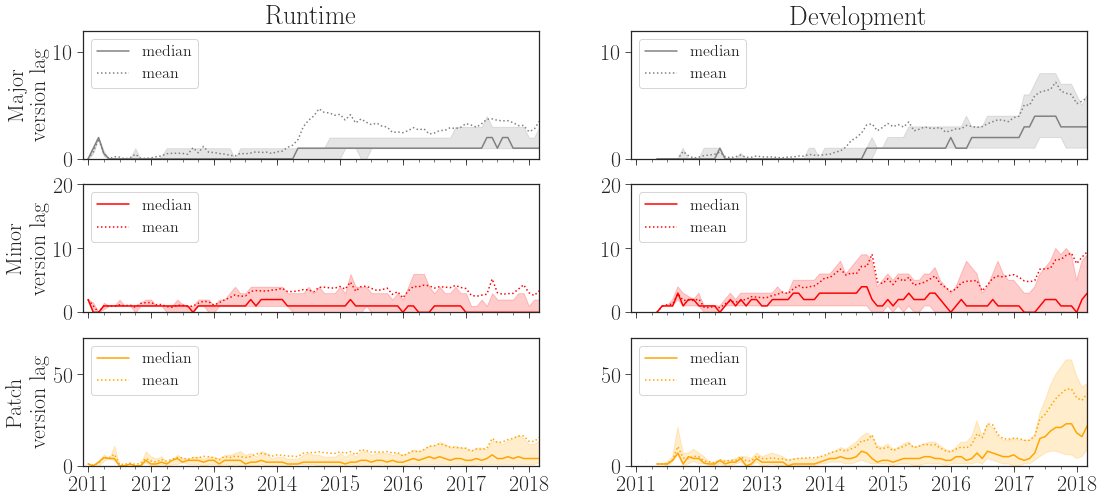

In [118]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)
fig.set_size_inches(18,8)
for index, genre in enumerate(['Runtime','Development']):
    size=[12,20,70]
    dfs={}
    for x in ['Patch','Minor','Major']:
        dfs[x]=(version_lag_sum_zeros.query('kind=="{}"'.format(genre)).
                groupby(pd.Grouper(key='date', freq='1M'))[x].
                describe()[['mean', '25%', '50%', '75%']] 
               )

    colors={}
    colors['Patch']='orange'
    colors['Minor']='r'
    colors['Major']='gray'


    for i, x in enumerate(['Major','Minor','Patch']):
        #fig, ax = plt.subplots()
        df_tmp=dfs[x]
        df_tmp['50%'].rename('median').plot(ax=axes[i][index], color=colors[x])
        df_tmp['mean'].plot(style=':',ax=axes[i][index], color=colors[x])
        axes[i][index].fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)

        axes[i][index].set(
            xlabel='',
            ylabel='{} \n version lag'.format(x),
            xlim=date_period,
            ylim=(0,size[i]),
        )
        if i == 0:
            axes[i][index].set(title=genre)
        if index==1:
            axes[i][index].set(ylabel='')

        axes[i][index].legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

#fig.savefig('../../../../jsep18technicallag/figures/version_lag_no_caret.png', bbox_inches='tight', facecolor='white')

# RQ2

In [4]:
technical_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', 
                          usecols=['package','version','version_lag','date','kind','constraint_type'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(technical_lag))
technical_lag.head(2)

51351426


,constraint_type,date,kind,package,version,version_lag
0,latest,2015-11-11,runtime,shaybagants-test,1.0.0,"0,0,0"
1,latest,2015-11-11,runtime,shaybagants-test,2.0.0,"0,0,0"


In [5]:
technical_lag=technical_lag.query('kind!="Optional"')
technical_lag['kind']=technical_lag['kind'].apply(lambda x: x.capitalize())
#technical_lag['date']=pd.to_datetime(technical_lag['date'])

# Remove pre-releases
technical_lag = technical_lag[~technical_lag.version.str.contains('-')]

# Remove spam packages
technical_lag=technical_lag[~technical_lag['package'].str.startswith(exclude_prefixes)]
technical_lag=technical_lag[~technical_lag['package'].str.endswith(exclude_suffixes)]
technical_lag=technical_lag[~technical_lag['package'].str.match(exclude_ghost)]

In [6]:
len(technical_lag)

45178711

In [7]:
technical_lag_outdated=technical_lag.query('version_lag!="0,0,0"').query('constraint_type!="latest"')
len(technical_lag_outdated)/len(technical_lag)

0.2576435170981306

In [7]:
df_tmp=technical_lag_outdated.groupby(['constraint_type','kind']).count()[['package']].reset_index()

In [9]:
for kind in ['Runtime','Development']:
    df_tmp = technical_lag_outdated.query('kind == "'+kind+'"').copy()
    l=float(len(df_tmp))
    df_tmp=df_tmp.groupby(['constraint_type','kind']).count()[['package']].reset_index()
    df_tmp['package']=df_tmp['package'].apply(lambda x: x*100.0/l)
    print(df_tmp)

  constraint_type     kind    package
0           caret  Runtime  49.226314
1           other  Runtime   4.673624
2          strict  Runtime  33.213445
3           tilde  Runtime  12.886618
  constraint_type         kind    package
0           caret  Development  63.895430
1           other  Development   2.417762
2          strict  Development  22.778789
3           tilde  Development  10.908019


In [9]:
df_tmp=technical_lag_outdated.groupby(['constraint_type']).count()[['package']].reset_index()
l=float(len(technical_lag_outdated))
df_tmp['package']=df_tmp['package'].apply(lambda x: x*100.0/l)
df_tmp

,constraint_type,package
0,caret,59.215608
1,other,3.137439
2,strict,26.107710
3,tilde,11.539242


In [83]:
df_tmp.groupby('kind').sum()

,package
kind,
Development,7926545
Runtime,3713457


In [84]:
df_tmp.groupby('constraint_type').sum()/l

,package
constraint_type,
caret,0.592156
other,0.031374
strict,0.261077
tilde,0.115392


In [98]:
df_tmp.groupby('constraint_type').sum()

,package
constraint_type,
caret,6892698
other,365198
strict,3038938
tilde,1343168


In [90]:
tech=technical_lag.groupby(['constraint_type','kind']).count()[['package']].reset_index()

In [100]:
a=(tech.groupby('constraint_type').sum()
 .merge(df_tmp.groupby('constraint_type').sum(),
        left_index=True,
        right_index=True,
        how='left'
       )
)
a['outdated'] = a['package_y']*100/ a['package_x']
a

,package_x,package_y,outdated
constraint_type,,,
caret,32192383,6892698.0,21.410959
latest,1671005,NaN,NaN
other,1407708,365198.0,25.942738
strict,6536462,3038938.0,46.492093
tilde,3371153,1343168.0,39.842985


In [93]:
6892698/32192383

0.2141095923218856

In [10]:
df_tmp=technical_lag_outdated.groupby(['constraint_type','kind']).count()[['package']].reset_index()
l=float(len(technical_lag_outdated))
df_tmp['package']=df_tmp['package'].apply(lambda x: x*100.0/l)

In [11]:
df_tmp.head()

,constraint_type,kind,package
0,caret,Development,43.511161
1,caret,Runtime,15.704447
2,other,Development,1.646434
3,other,Runtime,1.491005
4,strict,Development,15.511776


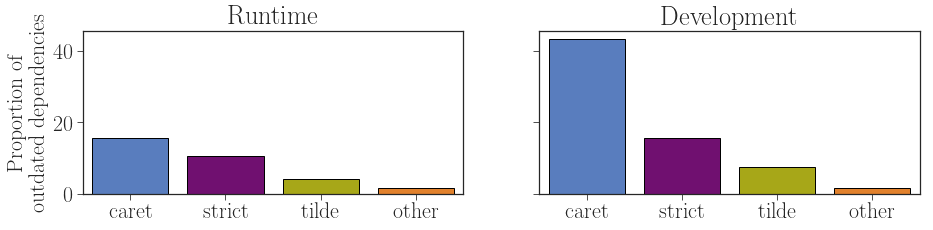

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

for i, kind in enumerate(['Runtime','Development']):
    data = df_tmp.query('kind == "'+kind+'"')
    ax = sns.barplot(x="constraint_type", y="package", palette=[blue,"purple",'y','#ff7f0e'], data=data,
                order=['caret','strict','tilde','other'],
                     ax=axes[i]
                #order=['Runtime','Development']
                    )
    ax.figure.set_size_inches(15,3)
    for patch in ax.patches:
        patch.set_edgecolor('black')
    #ax.legend('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(kind)
axes[0].set_ylabel('Proportion of \n outdated dependencies')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)
ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_lag.eps', bbox_inches='tight', facecolor='white')

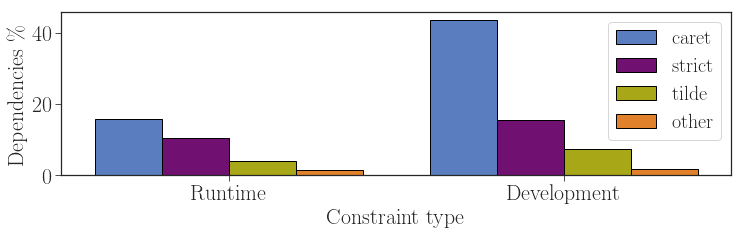

In [8]:

ax = sns.barplot(x="kind", y="package", hue="constraint_type", palette=[blue,"purple",'y','#ff7f0e'], data=df_tmp,
                hue_order=['caret','strict','tilde','other'],
                order=['Runtime','Development'])
ax.figure.set_size_inches(12,3)
ax.set_xlabel('Constraint type')
ax.set_ylabel('Dependencies \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend( loc='upper right', bbox_to_anchor=(1, 1), fontsize=20)#,ncol=3)#, fancybox=True, shadow=True)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_lag.eps', bbox_inches='tight', facecolor='white')

#### constraints evolution

In [42]:
df_tmp_orig=technical_lag[['package','constraint_type','kind','date']]
df_tmp_orig['date']=df_tmp_orig['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
df_tmp=(df_tmp_orig.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp_orig[['kind','date','package']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

In [44]:
df_tmp.head(2)

,constraint_type,kind_x,date,package_x,kind_y,package_y
0,caret,Development,2013-08,60,Development,33665
1,caret,Development,2013-08,60,Runtime,45602


In [45]:
df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['package_x']/df_tmp['package_y']
df_tmp.drop(['package_x','package_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head(2)

,constraint_type,kind,date,dependency
0,caret,Development,2013-08-01,0.001782
2,caret,Development,2013-09-01,0.000883


In [46]:
df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])
#df_tmp_all.to_csv('../../../jsep2018/csv/packages/ready/constraint_evolution_num.csv', index=False, sep=";")

In [47]:
#df_tmp_all=pd.read_csv('../../../jsep2018/csv/packages/ready/constraint_evolution_num.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

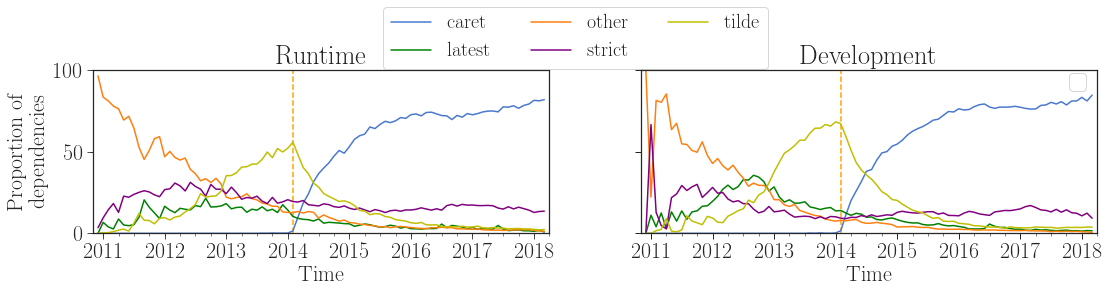

In [50]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, kind in enumerate(['Runtime','Development']):
    
    ax=df_tmp_all.query('kind=="'+kind+'"').plot(x="date", color=[blue,"g",'#ff7f0e','purple','y'],
                                                 #color=[blue,"green",'yellow','pink','orange'],
                                                 ax=axes[index])#, ax=axes[int(i/2)][j], label=type)    

    ax.set_ylabel('Proportion of\n dependencies')
    ax.set_xlabel('Time')
#    ax.figure.set_size_inches(12,3.5)
    plt.tick_params(axis='both', which='major', width=1)
    ax.set_ylim(0,100)
    ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.5, 1.45))
    ax.set_title(kind)
    ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))
ax.legend('',loc='upper right', bbox_to_anchor=(1, 1.05))

axes[0].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
axes[1].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)


#axes[0].vlines(pd.to_datetime('2017-05-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

#axes[0].vlines(pd.to_datetime('2016-03-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
#axes[0].vlines(pd.to_datetime('2017-10-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
#axes[1].vlines(pd.to_datetime('2017-10-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
fig.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_evolution.eps', bbox_inches='tight', facecolor='white')

In [ ]:
# Do the same but only for outdated dependencies

In [36]:
df_tmp_orig=technical_lag_outdated[['package','constraint_type','kind','date']]
df_tmp_orig['date']=df_tmp_orig['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

df_tmp=(df_tmp_orig.groupby(['constraint_type','kind','date']).count().
        reset_index().
        merge(df_tmp_orig[['kind','date','package']].groupby(['kind','date']).count().reset_index(),
              left_on="date",
              right_on='date',
              how="left")
       )

df_tmp=df_tmp.query('kind_x==kind_y')
df_tmp['dependency']=df_tmp['package_x']/df_tmp['package_y']
df_tmp.drop(['package_x','package_y','kind_y'], axis=1, inplace=True)
df_tmp.rename(columns={'kind_x':'kind'}, inplace=True)
df_tmp['date']=df_tmp['date'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df_tmp.head(2)


df_tmp_run=(df_tmp.query('kind=="Runtime"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_run['kind']='Runtime'

df_tmp_dev=(df_tmp.query('kind=="Development"').drop('kind', axis=1).
    pivot(index='date', columns='constraint_type', values='dependency').
     fillna(0)
    ).reset_index()
df_tmp_dev['kind']='Development'
df_tmp_all=pd.concat([df_tmp_run, df_tmp_dev])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
#df_tmp_all=pd.read_csv('../../../jsep2018/csv/packages/ready/constraint_evolution_outdated.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
#df_tmp_run['date']=df_tmp_run['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
for x in df_tmp_all:
    if x=="date" or x=="kind":
        continue
    df_tmp_all[x]=df_tmp_all[x].apply(lambda x: float(x)*100)
df_tmp_all['date']=pd.to_datetime(df_tmp_all['date'])
df_tmp_all['kind']=df_tmp_all['kind'].apply(lambda x: x.capitalize())

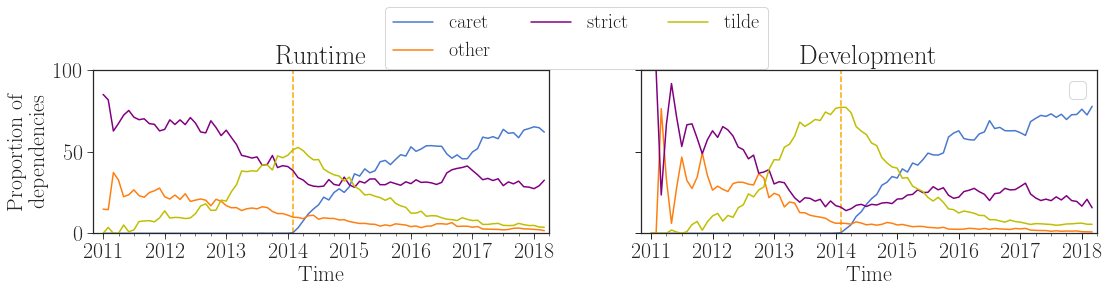

In [41]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, kind in enumerate(['Runtime','Development']):
    
    ax=df_tmp_all.query('kind=="'+kind+'"').plot(x="date",  ax=axes[index], 
                                                 color=[blue,"#ff7f0e",'purple','y'])#, ax=axes[int(i/2)][j], label=type)    

    ax.set_ylabel('Proportion of\n dependencies')
    ax.set_xlabel('Time')
#    ax.figure.set_size_inches(12,3.5)
    plt.tick_params(axis='both', which='major', width=1)
    ax.set_ylim(0,100)
    ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.5, 1.45))
    ax.set_title(kind)
    ax.set_xlim(pd.to_datetime("2010-11-01"),pd.to_datetime("2018-04-01"))
ax.legend('')

axes[0].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
axes[1].vlines(pd.to_datetime('2014-02-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)


#axes[0].vlines(pd.to_datetime('2017-05-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

#axes[0].vlines(pd.to_datetime('2016-03-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
#axes[0].vlines(pd.to_datetime('2017-10-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
#axes[1].vlines(pd.to_datetime('2017-10-01'), 0,100, colors='red', linestyles='dashed', alpha=1)
fig.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/constraints_evolution_outdated.pdf', bbox_inches='tight', facecolor='white')

# JUST CHECKS

In [28]:
a=versions.query('package=="angular"').query('date >= "2016-11-24" and date <"2016-12-23"')

In [29]:
a['package']="p"

In [58]:
versions.query('date<"2014"').package.drop_duplicates().size

51036

In [60]:
len(versions.query('date<"2014"')[['package','version']].drop_duplicates())

268115

In [62]:
versions.head()

,package,version,date,release_type,semver
0,0,0.0.0,2014-04-01,initial,0.0.0
1,0-,0.0.1,2017-03-06,initial,0.0.1
2,0----,1.0.0,2017-10-29,initial,1.0.0
3,0-0,1.0.2,2016-12-04,initial,1.0.2
4,0-9,0.0.1,2017-03-06,initial,0.0.1


In [65]:
versions['date']=versions['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

In [66]:
versions=versions.groupby(['date','release_type']).count()[['version']].reset_index()

In [69]:
versions=(versions.
    pivot(index='date', columns='release_type', values='version').
     fillna(0)
    ).reset_index()

In [74]:
versions['date']=pd.to_datetime(versions['date'])

(734107.0, 736726.0)

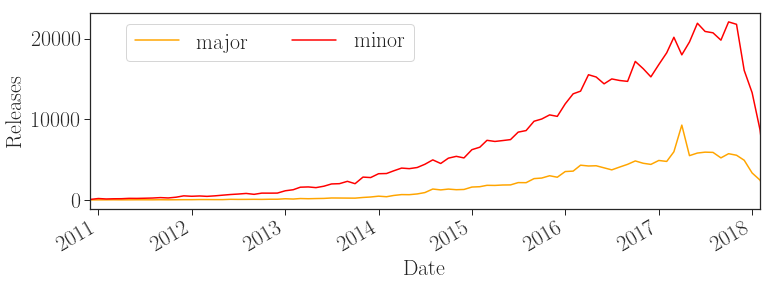

In [80]:
ax=versions[['major','minor','date']].plot(x='date', color=['orange','red','green','blue'])

ax.set_ylabel('Releases')
ax.set_xlabel('Date')
ax.figure.set_size_inches(12,4)
plt.tick_params(axis='both', which='major', width=1)
plt.legend( prop={'size': 22, 'weight':'bold'}, ncol=2, bbox_to_anchor=(0.5, 1))
#ax.set_ylim(0,100)
ax.set_xlim(pd.to_datetime('2010-12-01'),pd.to_datetime('2018-02-01'))
#ax.vlines(pd.to_datetime('2017-12-19'), 0, 150000, color='black', linestyles='--')


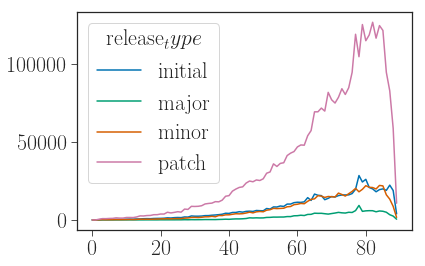

In [72]:
ax=versions.plot()
ax.set_xlim(pd.to_datetime('2014-07-01'),pd.to_datetime('2018-02-01'))
ax.figure.set_size_inches(12,4)
ax.vlines(pd.to_datetime('2017-12-01'), 0,200000, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-10-01'), 0,200000, colors='red', linestyles='dashed', alpha=1)

#ax.vlines(pd.to_datetime('2017-11-08'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
#ax.vlines(pd.to_datetime('2017-11-28'), 0,20000, colors='orange', linestyles='dashed', alpha=1)
#ax.vlines(pd.to_datetime('2018-01-06'), 0,20000, colors='orange', linestyles='dashed', alpha=1)


# More analysis

In [8]:
tech=technical_lag[['package','version']].drop_duplicates()

In [9]:
tech['pre']=tech['version'].apply(lambda x: x.split('.')[2].isdigit())

In [10]:
tech.groupby('pre').count()

,package,version
pre,,
False,331234,331234
True,3644212,3644212


In [11]:
len(tech)

3975446

In [5]:
len(versions.query('date<"2016"')) - len(versions.query('date<"2015"'))

713086

In [6]:
len(versions.query('date<"2015"')) 

653987

In [8]:
aaaa=technical_lag.query('date > "2014-02-19" and date < "2014-03"')

In [37]:
aaaa=technical_lag.query('version_lag!="0,0,0"').query('constraint_type=="caret" or constraint_type=="tilde"')

In [17]:
aaaa.query('version_lag>"1,"').groupby('constraint_type').count()

,constraint,date,package,kind,version_lag
constraint_type,,,,,
caret,29,29,29,29,29
tilde,941,941,941,941,941


In [38]:
aaaa['zero']=aaaa['constraint'].apply(lambda x: True if x.split('.')[0]=="~0" or x.split('.')[0]=="^0"
                                     else False)

In [41]:
1879056/len(aaaa.query('zero == True'))#/len(aaaa)

0.778340332940792

In [40]:
aaaa.query('zero == True').groupby('constraint_type').count()

,constraint,date,package,kind,version_lag,zero
constraint_type,,,,,,
caret,1879056,1879056,1879056,1879056,1879056,1879056
tilde,535127,535127,535127,535127,535127,535127


In [27]:
aaaa=aaaa.query('zero == True')

In [28]:
aaaa['date']=aaaa['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
aaaa=aaaa.groupby(['constraint_type','date']).count()[['package']].reset_index()

In [32]:
aaaaaaaa=(aaaa.
    pivot(index='date', columns='constraint_type', values='package').
     fillna(0)
    ).reset_index()

In [34]:
aaaaaaaa['date']=pd.to_datetime(aaaaaaaa['date'])

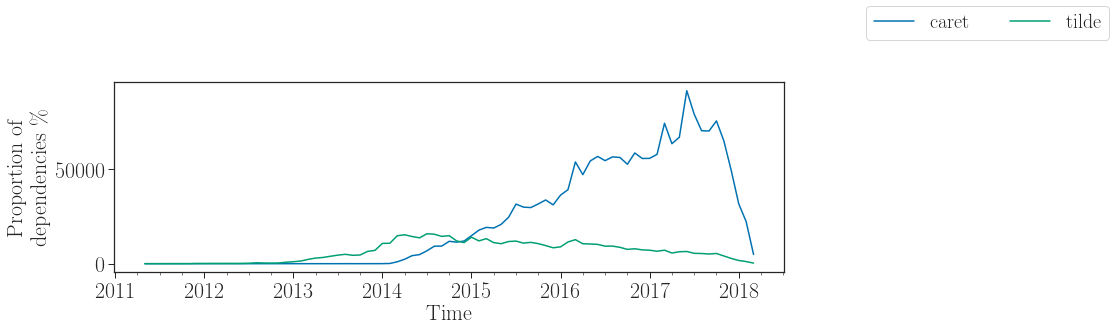

In [35]:
ax=aaaaaaaa.plot(x="date")#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n dependencies \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1.5, 1.45))


In [29]:
versions['zero']=versions['version'].apply(lambda x: 'True' if x.split('.')[0]=="0"
                                       else 'False')

In [30]:
versions['date']=versions['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])

In [52]:
if True:
    technical_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', usecols=['dependency'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
    print(len(technical_lag))
    technical_lag.head(2)

51351426


In [53]:
len(technical_lag.query('constraint=="latest"'))

849644

In [42]:
mask= versions.package.isin(technical_lag.dependency.drop_duplicates())
versions=versions[mask]

In [43]:
aaaaa=versions.groupby(['zero','date']).count()[['version']].reset_index()
aaaaa2=versions.groupby(['date']).count()[['package']].reset_index()

In [44]:
aaaaa=(aaaaa.
    pivot(index='date', columns='zero', values='version').
     fillna(0)
    ).reset_index()

In [45]:
versions['date']=pd.to_datetime(versions['date'])

In [46]:
aaaaa3=(aaaaa.
       merge(aaaaa2,
             left_on='date',
             right_on='date',
             how='left')
       .fillna(0)
       .reset_index()
      )

In [47]:
aaaaa3['initial']=aaaaa3['True']/aaaaa3['package']
aaaaa3['major']=aaaaa3['False']/aaaaa3['package']


In [48]:
aaaaa3.rename(columns={'initial':'0.y.z', 'major':'other'}, inplace=True)

(0, 1)

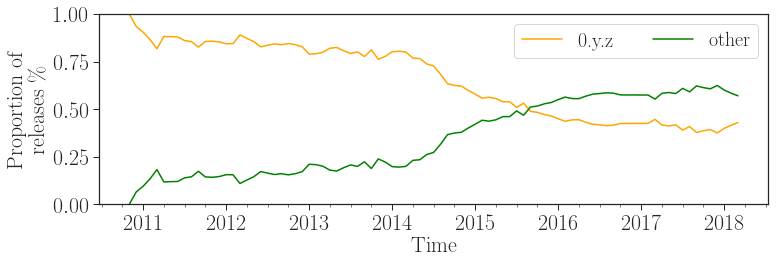

In [49]:
ax=aaaaa3.query('date!="1970-01-01"')[['date','0.y.z','other']].plot(x="date", color=['orange','green'])#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n releases \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1, 1))
ax.set_ylim(0,1)
#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/version_zero.png', bbox_inches='tight', facecolor='white')

In [50]:
aaaaa3.query('date=="2014-01-01"')

,index,date,False,True,package,0.y.z,other
39,39,2014-01-01,2461.0,9957.0,12416,0.801949,0.198212


In [51]:
aaaaa3.query('date=="2015-01-01"')

,index,date,False,True,package,0.y.z,other
51,51,2015-01-01,9213.0,12683.0,21888,0.57945,0.420916
